<a href="https://colab.research.google.com/github/ontenkutsenko/DL_Skin_Disease_Classification/blob/main/Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [375]:
# !pip install tensorflow_addons

import tensorflow_addons as tfa

import pickle

import pandas as pd
import numpy as np
import os
import requests
from tqdm import tqdm
import shutil

from tensorflow.keras.applications import ResNet50, VGG16, VGG19
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2

from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import time

from sklearn.metrics import f1_score
import seaborn as sns
from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Importing the data

In [8]:
#download weights of the best model

!gdown 16FJYqv05B9l2xJUsWw-glSmIkbjfMKcJ

Downloading...
From: https://drive.google.com/uc?id=16FJYqv05B9l2xJUsWw-glSmIkbjfMKcJ
To: /content/weights_history_input_128.h5
100% 61.5M/61.5M [00:00<00:00, 61.5MB/s]


In [9]:
#download images

!gdown 1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc

Downloading...
From (original): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc
From (redirected): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc&confirm=t&uuid=f762a753-2919-49cb-851b-c2e0bf529c3c
To: /content/Images for project.zip
100% 1.42G/1.42G [00:18<00:00, 75.7MB/s]


In [10]:
!unzip -q "/content/Images for project.zip" -d /content/

In [11]:
!rm '/content/Images for project.zip'

#### Sorting the images into separate train-val-test folders

In [131]:
url = 'https://raw.githubusercontent.com/ontenkutsenko/DL_Skin_Desease_Classification/main/Data/fitzpatrick17k.csv'
df = pd.read_csv(url).dropna(subset = ['url'])
df = df.sample(frac=1, random_state=10).reset_index(drop=True)

Our dataset contains information of skin color, which may be really important in case of Computer Vision task. We don't want our model to be biased, so we will stratify data in train, validation and test not only by label, but by every skin color, using fitzpatrick_scale. It will help to achieve better generalization and make validation stage more reliable

In [132]:
df['rank'] = df.groupby(['label', 'fitzpatrick_scale']).cumcount()/(df.groupby(['label', 'fitzpatrick_scale']).transform('count')['url'] - 1)

In [133]:
def assign_split(row, proportion):
    if row['rank'] < proportion['train']:
        return 'train'
    elif row['rank'] < proportion['train']+proportion['test']:
        return 'test'
    else:
        return 'val'

In [134]:
# Proportions do not exactly match what we defined because of rare skin color and class combinations that

proportion = {
    'train': 0.70,
    'val': 0.10,
    'test': 0.20
}

df['split'] = df.apply(lambda row: assign_split(row, proportion), axis=1)
df.split.value_counts()/len(df)

split
train    0.687712
test     0.188800
val      0.123488
Name: count, dtype: float64

In [16]:
shutil.rmtree('/content/dataset', ignore_errors=True)

source_folder = '/content/Images for project'
destination_folder = '/content/dataset'


for i in range(len(df)):
  try:
    source_file = os.path.join(source_folder, df['url'][i].split('/')[-1])
    destination_file = os.path.join(destination_folder, df['split'][i], df['label'][i], f"{df['url'][i].split('/')[-1]}.jpg")
    os.makedirs(os.path.dirname(destination_file), exist_ok=True)

    shutil.move(source_file, destination_file)
  except:
    print(source_file, ' doesn\'t exist')

/content/Images for project/img?imageId=4030  doesn't exist
/content/Images for project/img?imageId=8364  doesn't exist
/content/Images for project/img?imageId=2767  doesn't exist
/content/Images for project/img?imageId=4031  doesn't exist
/content/Images for project/img?imageId=5399  doesn't exist
/content/Images for project/img?imageId=2766  doesn't exist
/content/Images for project/img?imageId=6724  doesn't exist
/content/Images for project/img?imageId=4505  doesn't exist
/content/Images for project/img?imageId=8362  doesn't exist
/content/Images for project/img?imageId=8363  doesn't exist


#### Define model and test data generator

In [17]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [97]:
batch_size = 64

input_size = (128,128)

test_generator = test_datagen.flow_from_directory(
        'dataset/test',
        batch_size=batch_size,
        shuffle = False,
        class_mode='categorical',
        target_size=input_size)

tf.compat.v1.reset_default_graph()

input_size = (128,128)
# Instance of our pretrained model we will use
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_size + (3,))
# Make only the top layers of the base model trainable
for layer in base_model.layers[:-4]:
    layer.trainable = False

model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu',
                     kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(114, activation='softmax')
    ])

print(model.layers[-1].weights[0])

sgd_optimizer = SGD(lr=0.001, momentum=0.9)

weighted_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'weighted', name = 'weighted_f1')
macro_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'macro', name = 'macro_f1')

model.compile(optimizer=sgd_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', weighted_f1_score, macro_f1_score])

model.load_weights('/content/weights_history_input_128.h5')

print(model.layers[-1].weights[0])

# for layer in model.layers[:]:
#     layer.trainable = False

Found 3118 images belonging to 114 classes.


<tf.Variable 'dense_1/kernel:0' shape=(1024, 114) dtype=float32, numpy=
array([[ 0.05314881, -0.05616507,  0.03736464, ..., -0.01097138,
        -0.03760929,  0.04293907],
       [ 0.03119954, -0.02206645, -0.04452955, ...,  0.01892607,
        -0.00825145,  0.05656117],
       [ 0.06097899,  0.04374356,  0.05684991, ...,  0.07031965,
        -0.048449  , -0.00797039],
       ...,
       [ 0.0125984 , -0.05709575, -0.01062131, ..., -0.05740297,
        -0.01385842,  0.00967754],
       [-0.03305538,  0.05425124,  0.02892317, ..., -0.00987282,
        -0.03504138,  0.00728226],
       [-0.01115276,  0.06033684, -0.06536736, ..., -0.02780619,
        -0.00521138,  0.01226394]], dtype=float32)>
<tf.Variable 'dense_1/kernel:0' shape=(1024, 114) dtype=float32, numpy=
array([[ 0.04465518, -0.06790195,  0.04509483, ..., -0.05579664,
        -0.02073681,  0.02370812],
       [ 0.07220843, -0.02652145, -0.02055929, ..., -0.02284409,
         0.01634226, -0.01124442],
       [-0.04432542,  0.067

#### Save predictions and true values

In [ ]:
predictions = model.predict(test_generator, verbose = 'auto')

predicted_classes = predictions.argmax(axis=1)

class_labels = list(test_generator.class_indices.keys())

for prediction in predicted_classes:
    print(class_labels[prediction])

In [100]:
predictions_copy = predictions.copy()

In [308]:
#create dataframe for analysis

url = 'https://raw.githubusercontent.com/ontenkutsenko/DL_Skin_Desease_Classification/main/Data/fitzpatrick17k.csv'
df1 = pd.read_csv(url).dropna(subset = ['url'])
df1['key'] = df1['label'] + '/' + df1['url'].apply(lambda x: x.split('/')[-1] + '.jpg')
df2 = pd.DataFrame({
    'key': test_generator.filenames,
    'true_class': test_generator.classes,
    'pred_class': predictions.argmax(axis=1),
    'pred_prob' : predictions.tolist()
})
reverse_dict = {value: key for key, value in test_generator.class_indices.items()}
df2['pred_label'] = df2['pred_class'].apply(lambda x: reverse_dict[x])

test_info = pd.merge(df1, df2, left_on='key', right_on='key')
test_info.head()

,md5hash,fitzpatrick_scale,fitzpatrick_centaur,label,nine_partition_label,three_partition_label,qc,url,url_alphanum,key,true_class,pred_class,pred_prob,pred_label
0,fa2911a9b13b6f8af79cb700937cc14f,1,1,photodermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicpphoto...,photodermatoses/photosensitivity18.jpg.jpg,75,75,"[0.009285243228077888, 0.0011654234258458018, ...",photodermatoses
1,e702b1a7dc40aa1d8e85ccdb019c4ab2,1,1,neutrophilic dermatoses,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicssweet...,neutrophilic dermatoses/sweet-syndrome50.jpg.jpg,68,75,"[0.00036442745476961136, 0.020064303651452065,...",photodermatoses
2,8438db40abd1eccfbc7ee4b469f1b6f1,4,3,necrobiosis lipoidica,inflammatory,non-neoplastic,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicnnecro...,necrobiosis lipoidica/necrobiois-lipoidica-dia...,63,75,"[0.0008953519281931221, 0.0006957424338907003,...",photodermatoses
3,b09233673fc585369e723ec841ed0acb,5,3,actinic keratosis,malignant epidermal,malignant,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicaactin...,actinic keratosis/actinic_keratoses83.jpg.jpg,5,86,"[0.0002434748166706413, 0.013781903311610222, ...",psoriasis
4,fb9640a13e0c11610684fe8c0f473cf2,2,2,syringoma,benign dermal,benign,NaN,https://www.dermaamin.com/site/images/clinical...,httpwwwdermaamincomsiteimagesclinicalpicssyrin...,syringoma/syringoma33.jpg.jpg,104,44,"[0.004604175221174955, 0.0029573021456599236, ...",keratosis pilaris


#### Define metrics and calculate performance from different perspectives

In [218]:
def top_n_accuracy(y_val, val_predictions, n):
  diff = np.min(np.abs(y_val.reshape(-1, 1) - np.argsort(val_predictions, axis=1)[:,-n:]), axis = 1)
  return np.count_nonzero(diff == 0)/len(diff)

In [226]:
print(top_n_accuracy(test_info['true_class'].to_numpy(), np.array(test_info['pred_prob'].to_list()), 1))
print(top_n_accuracy(test_info['true_class'].to_numpy(), np.array(test_info['pred_prob'].to_list()), 3))
print(top_n_accuracy(test_info['true_class'].to_numpy(), np.array(test_info['pred_prob'].to_list()), 5))
print(f1_score(test_info['true_class'].to_numpy(), test_info['pred_class'].to_numpy(), average='weighted'))
print(f1_score(test_info['true_class'].to_numpy(), test_info['pred_class'].to_numpy(), average='macro'))

0.28960872354073125
0.45349583066067994
0.5461834509300834
0.26915725148301156
0.23895825840363596


In [ ]:
  # weighted_f1_cat = f1_score(cat_slice_df['true_class'].to_numpy(),
  #                            cat_slice_df['pred_class'].to_numpy())
  # macro_f1_cat = f1_score(cat_slice_df['true_class'].to_numpy(),
  #                         cat_slice_df['pred_class'].to_numpy(),
  #                         average='macro')

100%|██████████| 114/114 [00:00<00:00, 155.47it/s]


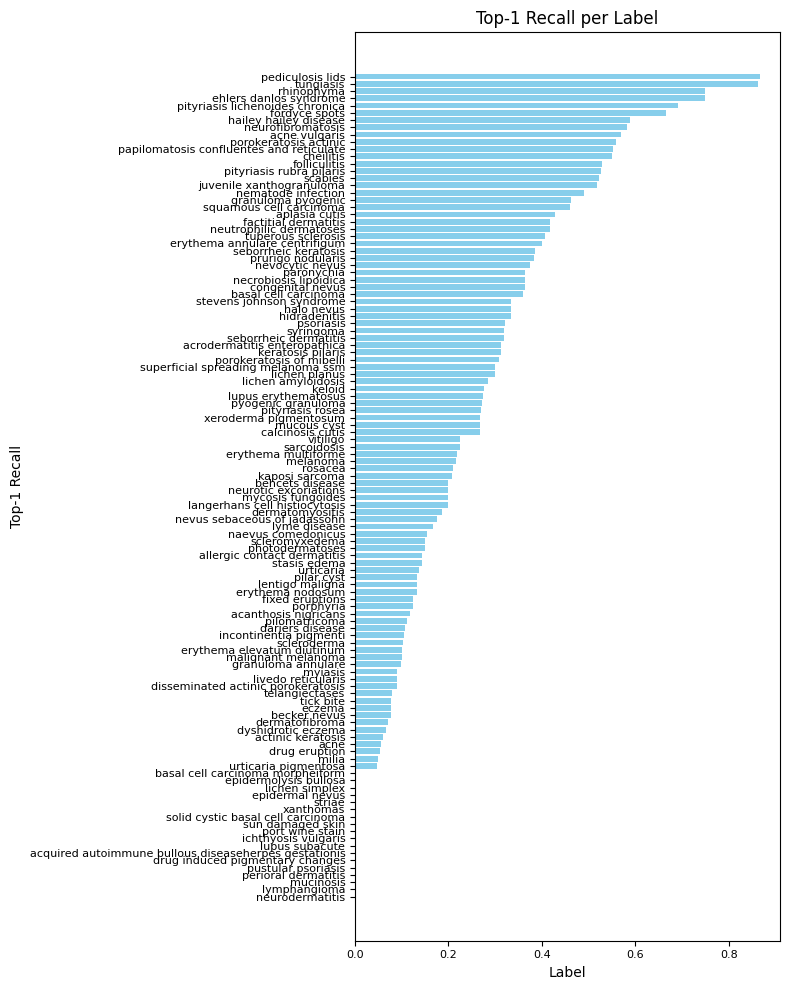

100%|██████████| 108/108 [00:00<00:00, 221.27it/s]


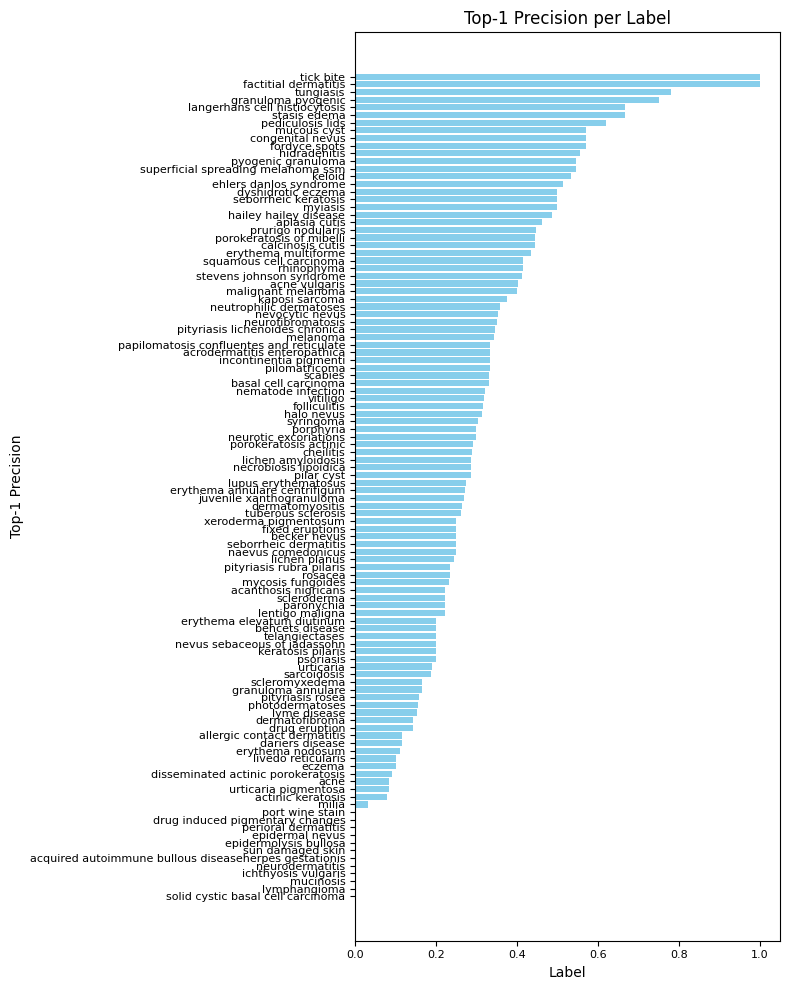

In [310]:
# Its not accuracy, but recall


category = 'label'

cat_calc = []
for i in tqdm(list(set(test_info[category]))):
  cat_slice_df = test_info[test_info[category] == i]
  top_1 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 1)
  top_3 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 3)
  top_5 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 5)

  cat_calc.append([i, len(cat_slice_df), top_1, top_3, top_5])
cat_performance_df = pd.DataFrame(cat_calc, columns= ['label', 'count', 'top_1_recall', 'top_3_recall', 'top_5_recall'])

sorted_df = cat_performance_df.sort_values(by='top_1_recall', ascending=True)


plt.figure(figsize=(8, 10))
plt.barh(sorted_df['label'], sorted_df['top_1_recall'], color='skyblue')
plt.title('Top-1 Recall per Label')
plt.xlabel('Label')
plt.ylabel('Top-1 Recall')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


# Its not accuracy, but precision

cat_calc = []
category = 'pred_label'
for i in tqdm(list(set(test_info[category]))):
  cat_slice_df = test_info[test_info[category] == i]
  top_1 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 1)
  top_3 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 3)
  top_5 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 5)

  cat_calc.append([i, len(cat_slice_df), top_1, top_3, top_5])
cat_performance_df_1 = pd.DataFrame(cat_calc, columns= ['label', 'count', 'top_1_precision', 'top_3_precision', 'top_5_precision'])

sorted_df = cat_performance_df_1.sort_values(by='top_1_precision', ascending=True)


plt.figure(figsize=(8, 10))
plt.barh(sorted_df['label'], sorted_df['top_1_precision'], color='skyblue')
# plt.plot(sorted_df['count'], sorted_df['label'], color='skyblue')
plt.title('Top-1 Precision per Label')
plt.xlabel('Label')
plt.ylabel('Top-1 Precision')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [331]:
# Recall on 30 biggest true classes

cat_performance_df.sort_values(by='count', ascending=False).head(30).drop('label', axis = 1).mean()

count           57.366667
top_1_recall     0.327999
top_3_recall     0.496695
top_5_recall     0.594777
dtype: float64

In [332]:
# Precision on 30 biggest predicted classes

cat_performance_df_1.sort_values(by='count', ascending=False).head(30).drop('label', axis = 1).mean()

count              71.566667
top_1_precision     0.313287
top_3_precision     0.471542
top_5_precision     0.556050
dtype: float64

In [330]:
# Recall on 30 smallest classes

cat_performance_df.sort_values(by='count', ascending=False).tail(30).drop('label', axis = 1).mean()

count           10.966667
top_1_recall     0.139387
top_3_recall     0.262826
top_5_recall     0.312429
dtype: float64

In [333]:
# Precision on 30 smallest predicted classes

cat_performance_df_1.sort_values(by='count', ascending=False).tail(30).drop('label', axis = 1).mean()

count              4.566667
top_1_precision    0.295529
top_3_precision    0.440741
top_5_precision    0.557989
dtype: float64

If we look on count number - average count of top predicted classes is way bigger than average count of top true classes. And the opposite for smallest. It means that distribution of predicted classes is way more extreme - model likes to predict some classes that it have seen more or know batter. Let's compare what are the most/least popular true classes and most/least popular predicted classes (!! might change when we put different model)

In [334]:
pop_pred = set(cat_performance_df_1.sort_values(by='count', ascending=False).head(30)['label'])
pop_true = set(cat_performance_df.sort_values(by='count', ascending=False).head(30)['label'])

len(pop_pred.intersection(pop_true))

23

In [335]:
unpop_pred = set(cat_performance_df_1.sort_values(by='count', ascending=False).tail(30)['label'])
unpop_true = set(cat_performance_df.sort_values(by='count', ascending=False).tail(30)['label'])

len(unpop_pred.intersection(unpop_true))

17

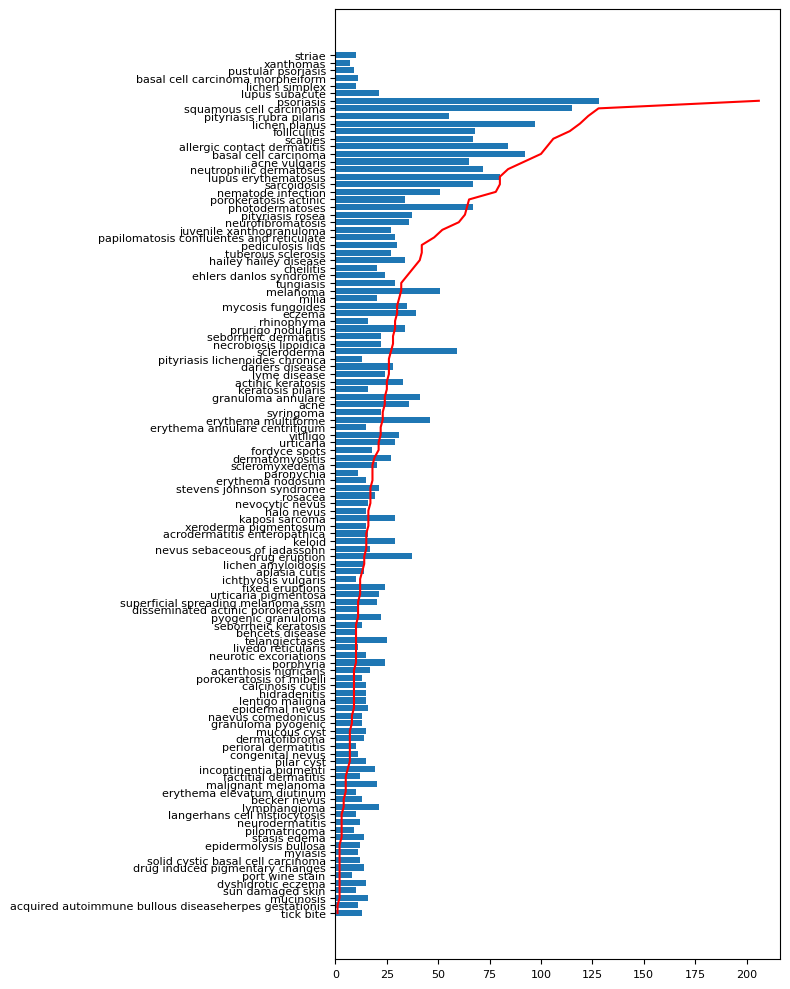

In [356]:
plt.figure(figsize=(8, 10))

plt.plot(cat_performance_df_1.sort_values(by = 'count')['count'],
         cat_performance_df_1.sort_values(by = 'count')['label'],
         color = 'red')
plt.barh(cat_performance_df['label'], cat_performance_df['count'])

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

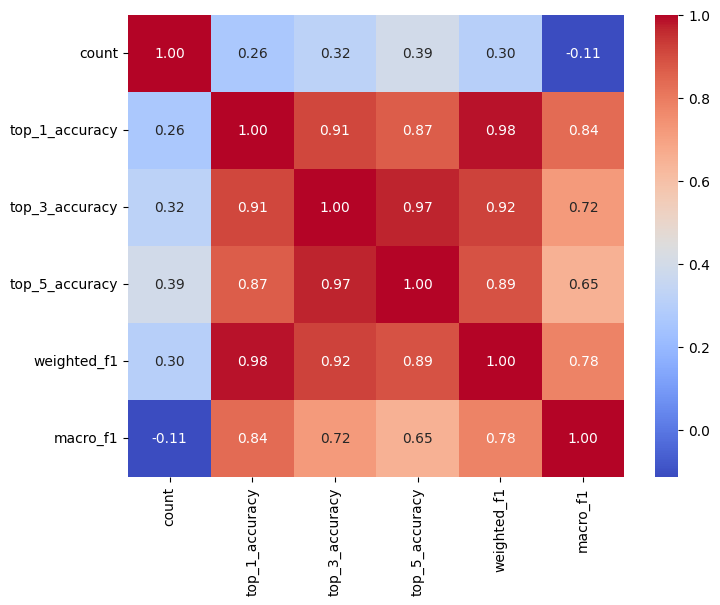

In [289]:
correlation_matrix = cat_performance_df.select_dtypes(include='number').corr()
# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

#### picture analysis

In [405]:
def display_images(image_paths):
    images_in_row = 4
    num_images = len(image_paths)
    num_rows = num_images // images_in_row + (num_images % images_in_row > 0)
    fig, axes = plt.subplots(num_rows, images_in_row, figsize=(16, images_in_row * num_rows))

    for i, path in enumerate(image_paths):
        row = i // images_in_row
        col = i % images_in_row
        ax = axes[row, col] if num_rows > 1 else axes[col]
        img = Image.open(path)
        ax.imshow(img)
        obs = test_info[test_info['key'] == path.split('test/')[1]]
        ax.set_title(f"Correct class: {obs['label'].values[0]}\nPredicted class: {obs['pred_label'].values[0]}", fontsize=8)


    # Hide axes
    for i in range( num_rows * images_in_row):
        row = i // images_in_row
        col = i % images_in_row
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.axis('off')



    plt.tight_layout()
    plt.show()

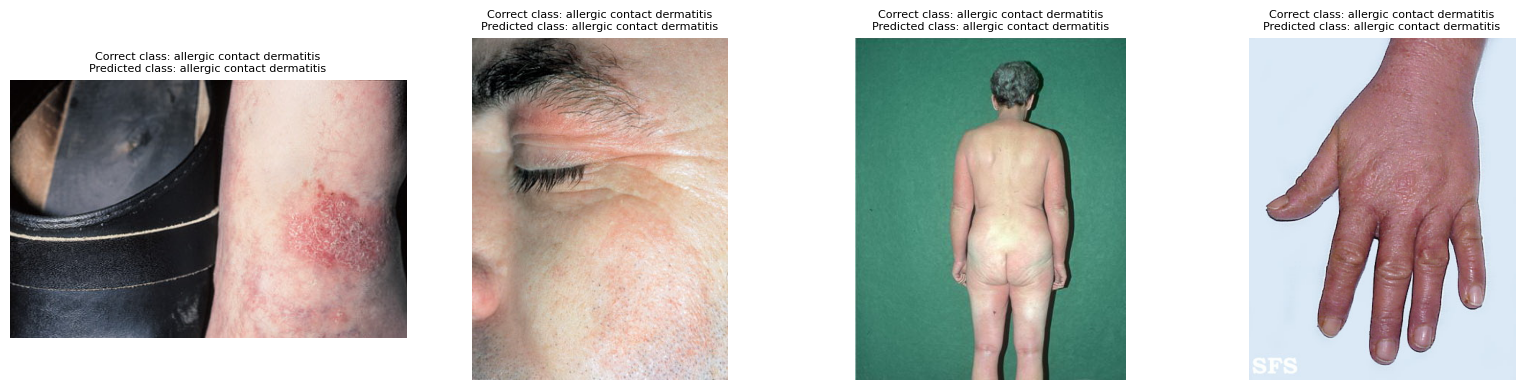

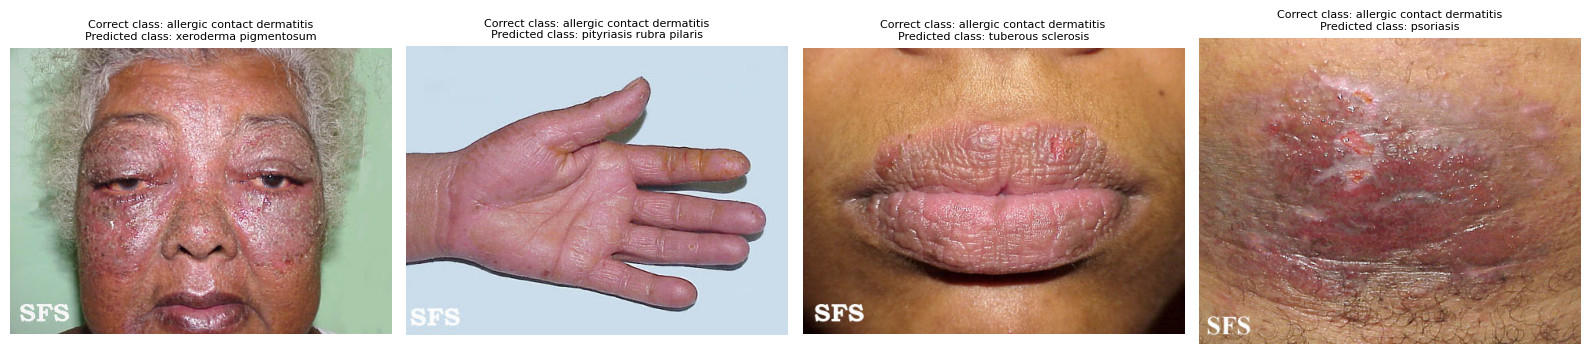

In [417]:
label = 'allergic contact dermatitis'

image_paths = test_info[(test_info['label'] == label) & (test_info['true_class'] == test_info['pred_class'])]['key'].apply(lambda x: '/content/dataset/test/' + x).tail(4).to_list()
display_images(image_paths)

image_paths = test_info[(test_info['label'] == label) & (test_info['true_class'] != test_info['pred_class'])]['key'].apply(lambda x: '/content/dataset/test/' + x).tail(4).to_list()

display_images(image_paths)

What else to do
- grad cam
- check cases when big share one class was transferred to another class
- different perspectives (benign/mailgnant, skin color)